In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats

In [2]:
''' Data Generation '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df

In [3]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [4]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [5]:
M=10
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [2.0741778660798085]
OLS beta_hat:  [0.23156350133774473]
OLS gamma_hat:  [-1.5118433346592741]
OLS theta_hat:  [1.0]
GLS alpha_hat:  [2.0352053405862134]
GLS beta_hat:  [0.26115731824161026]
GLS gamma_hat:  [-1.5116801602765508]
GLS theta_hat:  [1.000000000000004]
OLS_bias_param_0 = -1.8742
OLS_bias_param_1 = 0.2684
OLS_bias_param_2 = 1.8118
OLS_bias_param_3 = -0.1000
OLS_RMSE = 1.3112
GLS_bias_param_0 = -1.8352
GLS_bias_param_1 = 0.2388
GLS_bias_param_2 = 1.8117
GLS_bias_param_3 = -0.1000
GLS_RMSE = 1.2959


In [6]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 100)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

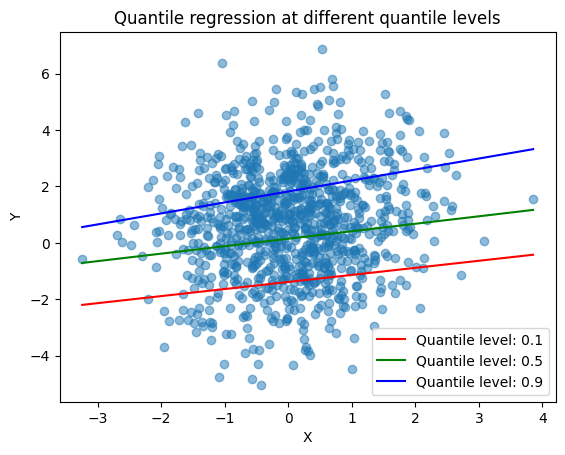

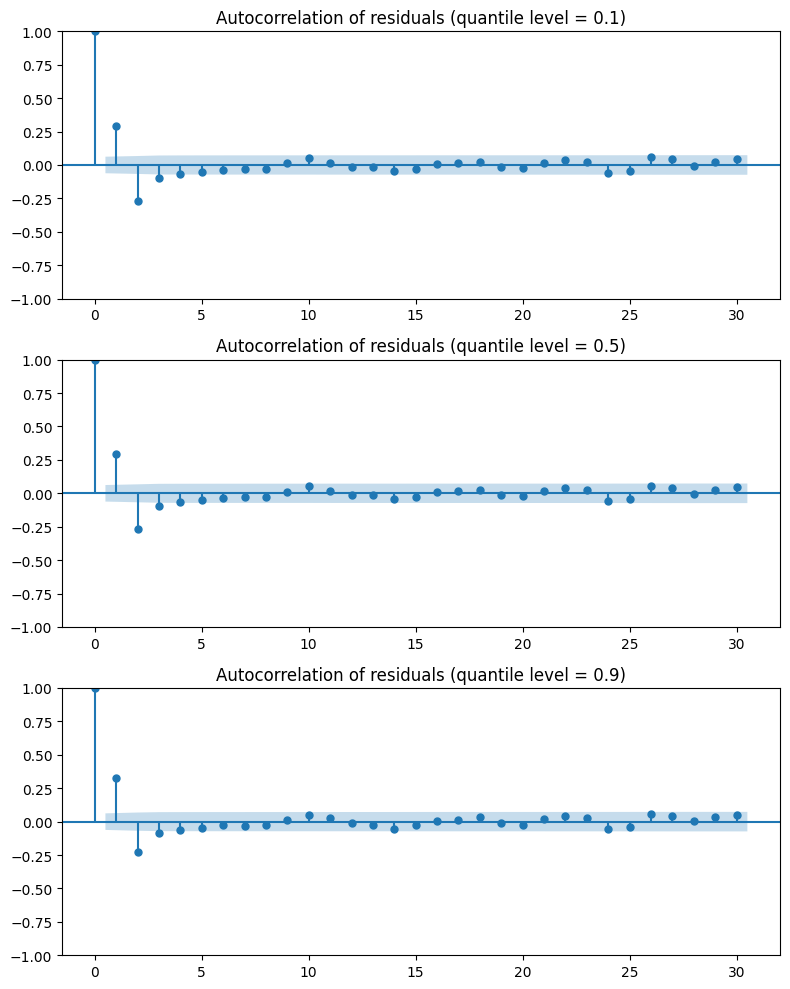

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3451
 Model:                       QuantReg   Bandwidth:                      0.4867
 Method:                 Least Squares   Sparsity:                        7.633
 Date:                Mon, 22 May 2023   No. Observations:                 1000
 Time:                        17:31:31   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.3888      0.078    -17.845      0.000      -1.542      -1.236
 x1             0.7595      0.040     18.828      0.000       0.680       0.839
 x2             0.2507      0.077      3.277      0.001       0.101   

In [7]:
fit_quantile(df)

In [88]:
def Laplace_estimation(df, p, M):

    def log_l_Asym_Lap(params, X, y, A):
        alpha, beta, gamma = params
        ll = 0 
        z = np.random.exponential(1, T)
        σ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ε = y - X @ params - θ * z 
        ll -= -T/2 * np.log(np.linalg.det(S)) - 1/2 * np.sum(1/z * np.linalg.inv(y - X @ params - θ * z) * np.linalg.inv(S) * (y - X @ params - θ * z))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    beta_laplace = []
    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.randn(T) 
        epsilon = np.random.laplace(0, 1, T) # Generate new errors for each iteration
        y = y + epsilon  # Update y with new errors
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        
        initial_values = np.array([0.2, 0.5, 0.3])
        ε = y - X @ initial_values
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    

    initial_val = np.array([0.2, 0.5, 0.3])
    initial_values = initial_values.reshape((1, -1)) #Actuals 0.2, 0.5, 0.3

      # Reshape to 2D array
    res = optimize.minimize(log_l_Asym_Lap, initial_val, args=(X, y, S), method='L-BFGS-B', bounds=[(-1, 1), (-1, 1), (-1, 1)])  # minimize the negative log-likelihood

    #res = optimize.minimize(loglikelihood_asymmetric_Laplace333, initial_values, args=(X, y, S), method='L-BFGS-B', bounds=[(-1, 1), (-1, 1), (-1, 1)]) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x
    succ = res.success
    #return beta_laplace, succ
    
    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    print("Laplace successful: {}".format(res.success))


In [89]:
#0.2, 0.5, 0.3
p = 0.4
M = 10
Laplace_estimation(df, p, M)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [45]:
p = 0.4
M = 100
Laplace_estimation(df, p, M)

Laplace parameter estimates:
alpha_l = 0.2000
beta_l = 0.5000
gamma_l = 0.3000
Laplace successful: True


In [47]:
p = 0.9
M = 10000
Laplace_estimation(df, p, M)

Laplace parameter estimates:
alpha_l = 0.2000
beta_l = 0.5000
gamma_l = 0.3000
Laplace successful: False


/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_28580/768339491.py:10: RuntimeWarning: invalid value encountered in log
  ll -= np.sum(np.log(alpha) + np.log(beta) + (1 / (alpha + beta)) * np.abs(ε) / σ)


In [48]:
def Laplace_estimation2(df, p, M):
    beta_laplace_list = [] # Create an empty list to store the beta_laplace estimates

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    for i in range(M):
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        θ = (1 - 2*p) / p * (1-p)
        ε_l = y - X @ beta_gls - θ * z
        ε_l = ε_l.reshape((-1, 1))

        acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=10, alpha=0.05)
        sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
        sigma2_array_l = np.full(T, sigma2_l)
        rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
        S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)

        def neg_log_likelihood(beta_gls, X, y, S_l):
            T  = len(y)
            resid = y - X @ beta_gls - θ * z
            a = (np.sqrt(τ_2)*np.sqrt(z))**2
            b = (ε_l**2)/a
            return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))

        beta_initial = np.array([0.2, 0.5, 0.3])
        res = optimize.minimize(neg_log_likelihood, beta_initial, args=(X, y, S_l)) # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x

        beta_laplace_list.append(beta_laplace) # Append the estimate to the list

    beta_laplace_list = np.array(beta_laplace_list) # Convert the list to a numpy array
    beta_laplace_mean = np.mean(beta_laplace_list, axis=0) # Calculate the mean of the estimates
    beta_laplace_std = np.std(beta_laplace_list, axis=0) # Calculate the standard deviation of the estimates

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f} +/- {:.4f}".format(beta_laplace_mean[0], beta_laplace_std[0]))
    print("beta_l = {:.4f} +/- {:.4f}".format(beta_laplace_mean[1], beta_laplace_std[1]))
    print("gamma_l = {:.4f} +/- {:.4f}".format(beta_laplace_mean[2], beta_laplace_std[2]))

In [50]:
p = 0.1
M = 10
Laplace_estimation2(df, p, M)

NameError: name 'T' is not defined